In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import cv2 as cv

from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam,RMSprop 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle

from keras.datasets import mnist

In [2]:
np.random.seed(1) # seed
df_train = pd.read_csv("C:/Users/vaibh/OneDrive/Desktop/Digit Recognition/train.csv") # Loading Dataset
df_train = df_train.iloc[np.random.permutation(len(df_train))] # Random permutaion for dataset (seed is used to resample the same permutation every time)

In [3]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29633,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36369,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16624,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

In [5]:
sample_size = df_train.shape[0] # Training set size
validation_size = int(df_train.shape[0]*0.1) # Validation set size 

# train_x and train_y
train_x = np.asarray(df_train.iloc[:sample_size-validation_size,1:]).reshape([sample_size-validation_size,28,28,1]) # taking all columns expect column 0
train_y = np.asarray(df_train.iloc[:sample_size-validation_size,0]).reshape([sample_size-validation_size,1]) # taking column 0

# val_x and val_y
val_x = np.asarray(df_train.iloc[sample_size-validation_size:,1:]).reshape([validation_size,28,28,1])
val_y = np.asarray(df_train.iloc[sample_size-validation_size:,0]).reshape([validation_size,1])

In [6]:
train_x.shape,train_y.shape

((37800, 28, 28, 1), (37800, 1))

In [7]:
df_test = pd.read_csv("C:/Users/vaibh/OneDrive/Desktop/Digit Recognition/test.csv")
test_x = np.asarray(df_test.iloc[:,:]).reshape([-1,28,28,1])

In [8]:
train_x = train_x/255
val_x = val_x/255
test_x = test_x/255

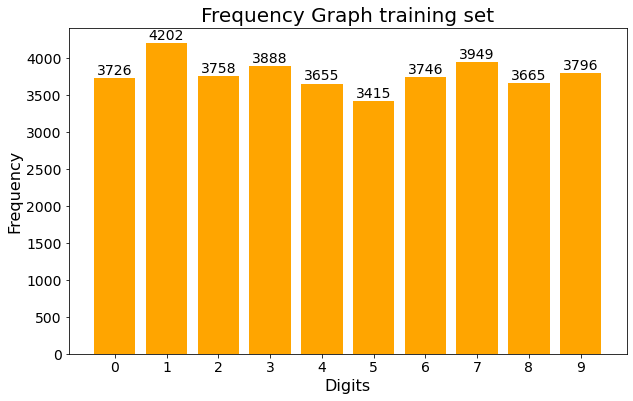

In [9]:
counts = df_train.iloc[:sample_size-validation_size,:].groupby('label')['label'].count()
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+50,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph training set",fontsize=20)
plt.savefig('digit_frequency_train.png')  
plt.show()

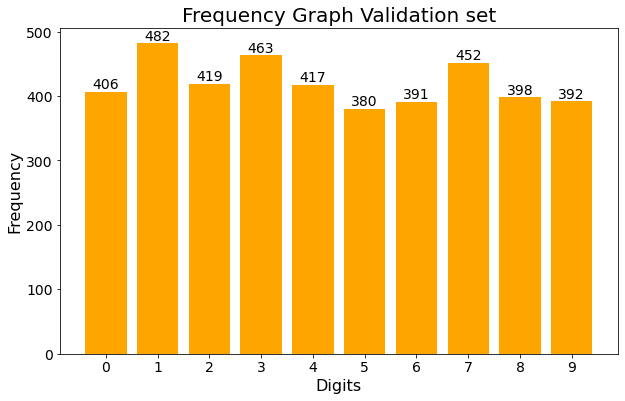

In [10]:
counts = df_train.iloc[sample_size-validation_size:,:].groupby('label')['label'].count()
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+5,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph Validation set",fontsize=20)
plt.savefig('digit_frequency_val.png')
plt.show()

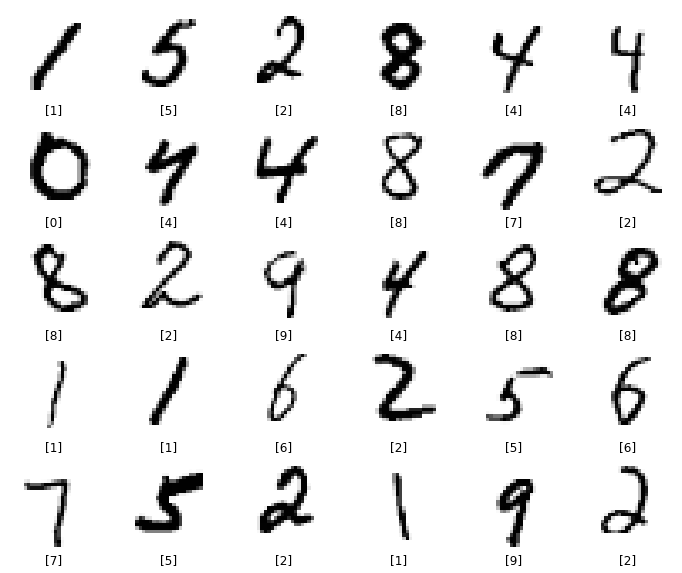

In [11]:
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train_x[i].reshape([28,28]), cmap= "Greys") 
    plt.axis("off")
    plt.title(str(train_y[i]), y=-0.20,color="black")
plt.savefig("digits.png")

In [12]:
model = models.Sequential()
# Block 1
model.add(Conv2D(32,3, padding  ="same",input_shape=(28,28,1)))
model.add(LeakyReLU())
model.add(Conv2D(32,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation="sigmoid"))

In [13]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

In [14]:
epochs = 20
batch_size = 256
history_1 = model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,validation_data=(val_x,val_y))

Epoch 1/20
148/148 [==============================] - 45s 303ms/step - loss: 0.3881 - accuracy: 0.8735 - val_loss: 0.1086 - val_accuracy: 0.9688
Epoch 2/20
148/148 [==============================] - 45s 307ms/step - loss: 0.0895 - accuracy: 0.9734 - val_loss: 0.0657 - val_accuracy: 0.9826
Epoch 3/20
148/148 [==============================] - 45s 307ms/step - loss: 0.0565 - accuracy: 0.9825 - val_loss: 0.0515 - val_accuracy: 0.9836
Epoch 4/20
148/148 [==============================] - 46s 307ms/step - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.0497 - val_accuracy: 0.9855
Epoch 5/20
148/148 [==============================] - 50s 336ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0522 - val_accuracy: 0.9850
Epoch 6/20
148/148 [==============================] - 49s 330ms/step - loss: 0.0302 - accuracy: 0.9901 - val_loss: 0.0531 - val_accuracy: 0.9831
Epoch 7/20
148/148 [==============================] - 50s 337ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0523 - val_ac

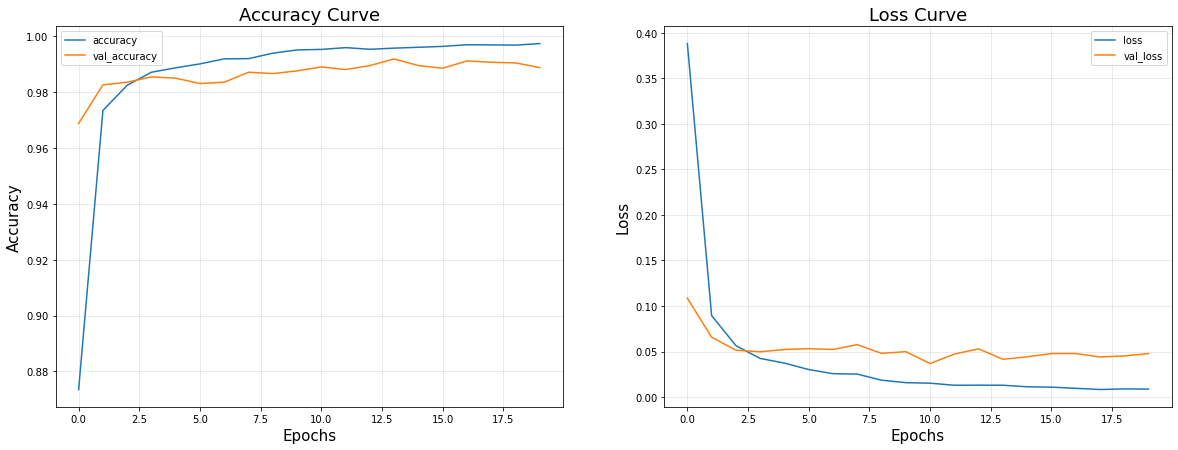

In [15]:
# Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(history_1.epoch,history_1.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch,history_1.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch,history_1.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch,history_1.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [16]:
val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1
        
print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])

Confusion Matrix: 

 [[406.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 473.   1.   0.   1.   1.   1.   5.   0.   0.]
 [  0.   0. 418.   0.   0.   0.   0.   0.   1.   0.]
 [  1.   0.   1. 457.   0.   2.   0.   0.   1.   1.]
 [  0.   0.   1.   0. 411.   0.   3.   1.   1.   0.]
 [  0.   0.   0.   0.   0. 373.   0.   0.   2.   5.]
 [  1.   0.   1.   0.   0.   1. 388.   0.   0.   0.]
 [  0.   1.   1.   0.   1.   0.   0. 448.   0.   1.]
 [  0.   0.   1.   0.   0.   0.   0.   0. 397.   0.]
 [  1.   0.   0.   0.   5.   1.   0.   2.   1. 382.]]

Errors in validation set:  47

Error Persentage :  1.119047619047619

Accuracy :  98.88095238095238

Validation set Shape : 4200


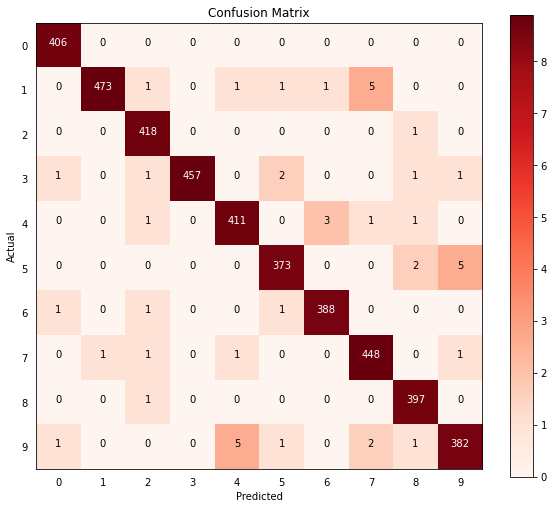

In [17]:
f = plt.figure(figsize=(10,8.5))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix+1),cmap="Reds")
plt.colorbar()
plt.tick_params(size=5,color="white")
plt.xticks(np.arange(0,10),np.arange(0,10))
plt.yticks(np.arange(0,10),np.arange(0,10))

threshold = confusion_matrix.max()/2 

for i in range(10):
    for j in range(10):
        plt.text(j,i,int(confusion_matrix[i,j]),horizontalalignment="center",color="white" if confusion_matrix[i, j] > threshold else "black")
        
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix1.png")
plt.show()

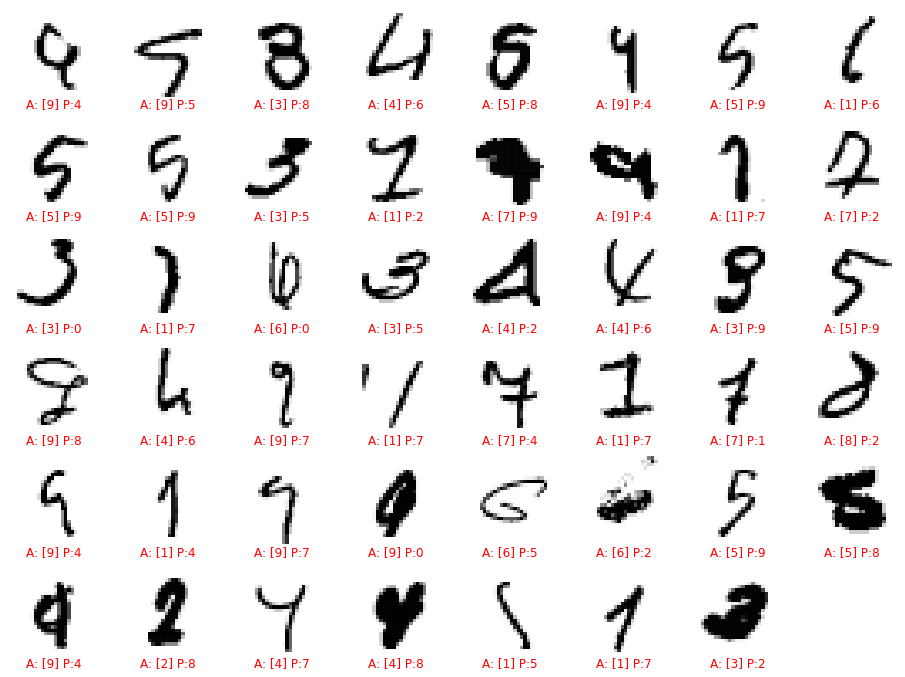

In [18]:
rows = 6
cols = 8

f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1
for i in range(val_x.shape[0]):
    if val_y[i]!=val_p[i]:
        f.add_subplot(rows,cols,sub_plot) 
        sub_plot+=1
        plt.imshow(val_x[i].reshape([28,28]),cmap="Greys")
        plt.axis("off")
        plt.title("A: "+str(val_y[i])+" P:"+str(val_p[i]), y=-0.15,color="Red")
plt.savefig("error_plots.png")
plt.show()

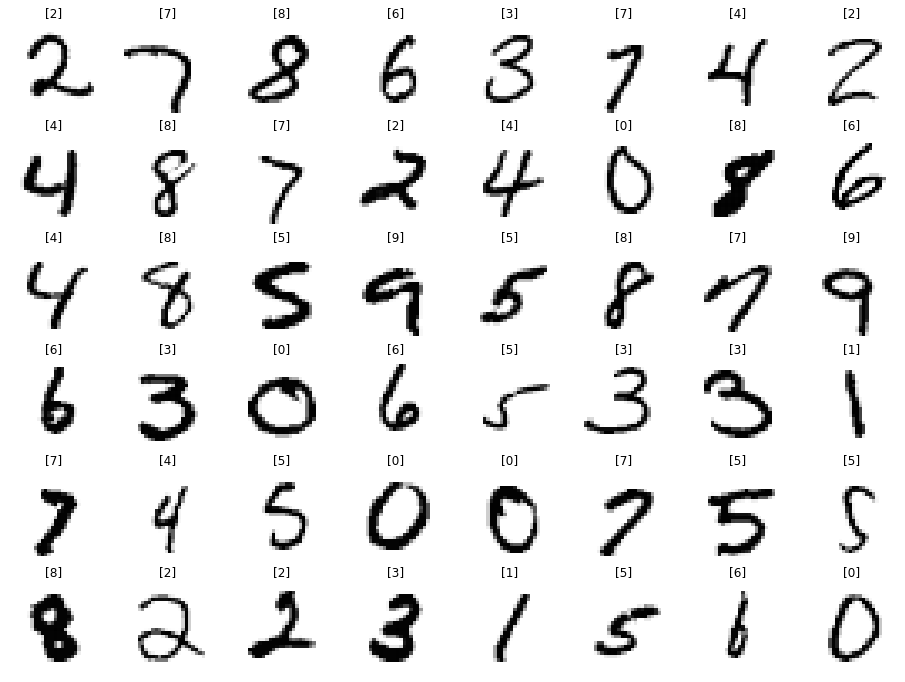

In [19]:
rows = 6
cols = 8

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(val_x[i].reshape([28,28]),cmap="Greys")
    plt.axis("off")
    plt.title(str(val_y[i]))

In [24]:
results = model.predict(test_x)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [26]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)